<a href="https://colab.research.google.com/github/srivennela-128/OIB-SIP/blob/main/Project_2_Proposal_Level_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# (Run once if needed)
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn plotly --quiet

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

sns.set(style="whitegrid")
%matplotlib inline

In [ ]:
# Step 1: Upload the file manually
from google.colab import files
uploaded = files.upload()

# Step 2: Load the CSV into a pandas DataFrame
import pandas as pd

df = pd.read_csv('ifood_df.csv')

# Step 3: Display first few rows
df.head()

Saving ifood_df.csv to ifood_df.csv


,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall
0,58138.0,0,0,58,635,88,546,172,88,88,...,0,0,0,0,1,0,0,1529,1441,0
1,46344.0,1,1,38,11,1,6,2,1,6,...,0,0,0,0,1,0,0,21,15,0
2,71613.0,0,0,26,426,49,127,111,21,42,...,1,0,0,0,1,0,0,734,692,0
3,26646.0,1,0,26,11,4,20,10,3,5,...,1,0,0,0,1,0,0,48,43,0
4,58293.0,1,0,94,173,43,118,46,27,15,...,0,0,0,0,0,0,1,407,392,0


In [ ]:
# Missing values summary
missing = df.isnull().sum().sort_values(ascending=False)
print("Missing values:\n", missing[missing>0])

# Drop rows fully empty
df = df.dropna(how='all')

# Option: For numeric columns, replace non-numeric artifacts and convert
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
# If some numeric columns are strings, convert safely:
for c in df.columns:
    if df[c].dtype == object:
        # try numeric convert if many numeric-like strings
        sample = df[c].dropna().head(20).astype(str)
        if sample.str.replace('.','',1).str.isnumeric().all():
            df[c] = pd.to_numeric(df[c], errors='coerce')

# Convert DtCustomer to datetime if present
if 'DtCustomer' in df.columns:
    df['DtCustomer'] = pd.to_datetime(df['DtCustomer'], errors='coerce')

# Simple imputation for missing Income: fill with median
if 'Income' in df.columns:
    df['Income'] = pd.to_numeric(df['Income'], errors='coerce')
    df['Income'].fillna(df['Income'].median(), inplace=True)

# For categorical missing: fill with 'Unknown'
for c in df.select_dtypes(include=['object']).columns:
    df[c] = df[c].fillna('Unknown')

print("After cleaning shape:", df.shape)


Missing values:
 Series([], dtype: int64)
After cleaning shape: (2205, 39)


/tmp/ipython-input-2935165894.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Income'].fillna(df['Income'].median(), inplace=True)


In [ ]:
# numeric summary
num = df.select_dtypes(include=[np.number])
num.describe().T

# helper function to print mean, median, mode, std for selected columns
def basic_stats(col):
    s = df[col].dropna()
    print(f"{col}: count={s.count()}, mean={s.mean():.2f}, median={s.median():.2f}, mode={s.mode().tolist()[:3]}, std={s.std():.2f}")

# example stats on a few important columns
for col in ['Income','Recency','NumStorePurchases','NumWebPurchases','NumDealsPurchases','MntMeatProducts','MntFruits']:
    if col in df.columns:
        basic_stats(col)

Income: count=2205, mean=51622.09, median=51287.00, mode=[7500.0], std=20713.06
Recency: count=2205, mean=49.01, median=49.00, mode=[56], std=28.93
NumStorePurchases: count=2205, mean=5.82, median=5.00, mode=[3], std=3.24
NumWebPurchases: count=2205, mean=4.10, median=4.00, mode=[2], std=2.74
NumDealsPurchases: count=2205, mean=2.32, median=2.00, mode=[1], std=1.89
MntMeatProducts: count=2205, mean=165.31, median=68.00, mode=[7], std=217.78
MntFruits: count=2205, mean=26.40, median=8.00, mode=[0], std=39.78


In [ ]:
# Tenure in days since DtCustomer if DtCustomer exists
import datetime
if 'DtCustomer' in df.columns:
    ref_date = df['DtCustomer'].max()  # or pd.Timestamp.today()
    df['tenure_days'] = (ref_date - df['DtCustomer']).dt.days

# Total spent across product categories (create if ingredients exist)
mnt_cols = [c for c in df.columns if c.lower().startswith('mnt')]
if mnt_cols:
    df['total_spent'] = df[mnt_cols].sum(axis=1)

# Total number of purchases
purchase_cols = [c for c in df.columns if 'num' in c.lower() and 'purchases' in c.lower()]
if purchase_cols:
    df['total_purchases'] = df[purchase_cols].sum(axis=1)

# Average purchase value (avoid divide by zero)
df['avg_purchase_value'] = df.apply(lambda r: r['total_spent']/r['total_purchases'] if (('total_spent' in r.index) and ('total_purchases' in r.index) and r['total_purchases']>0) else 0, axis=1)

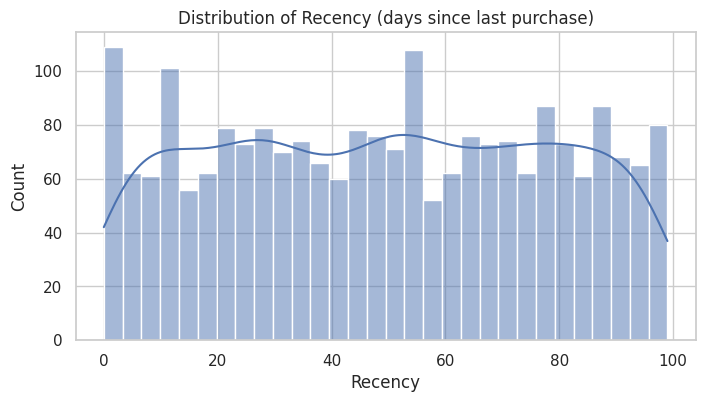

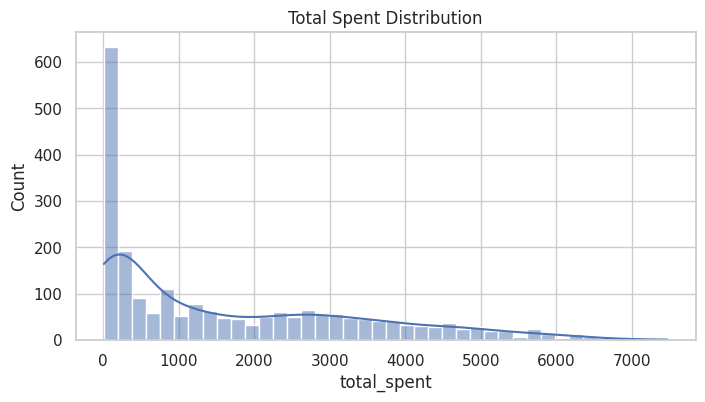

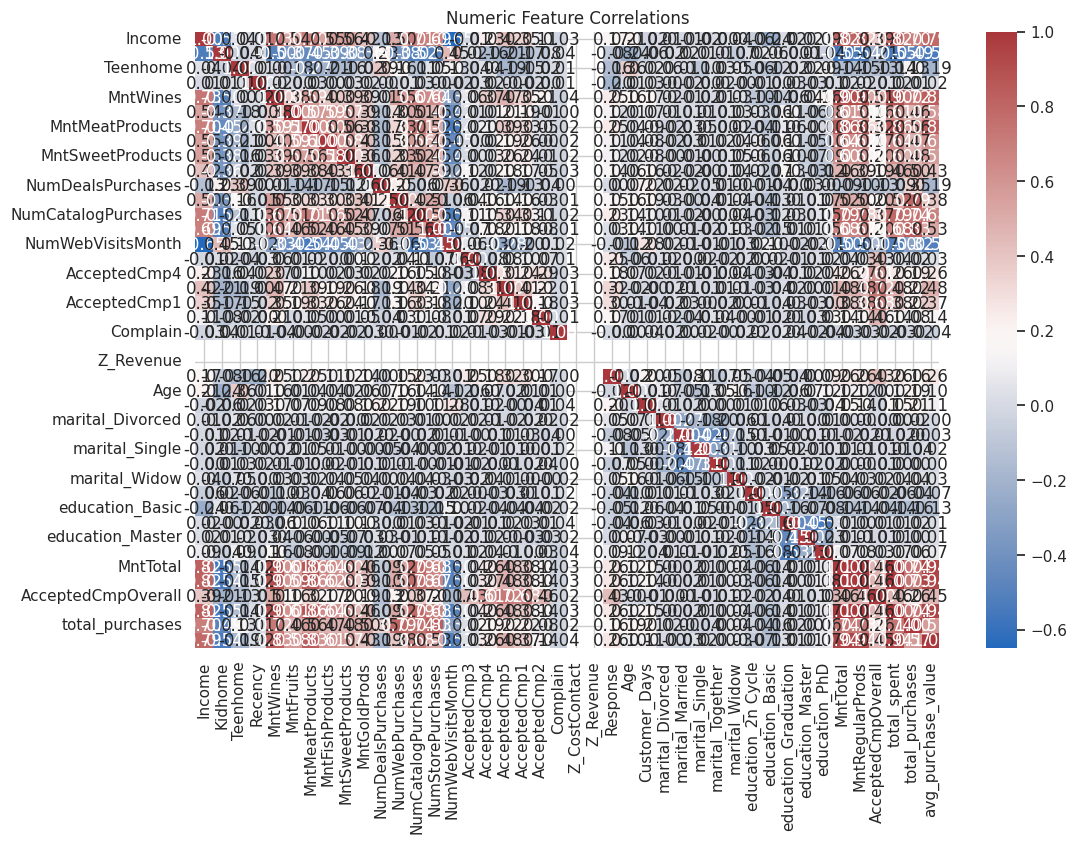

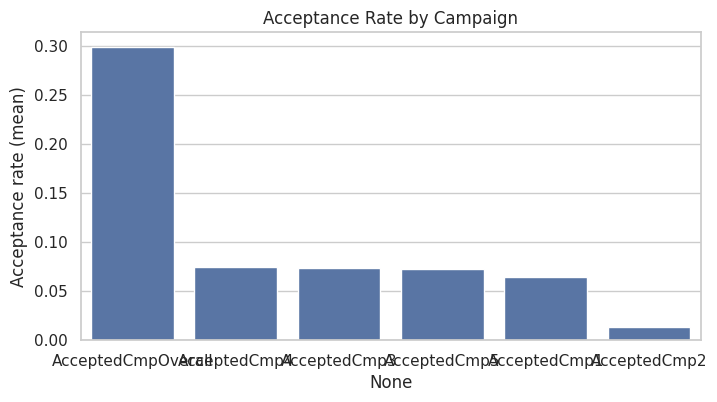

In [ ]:
# 6.1 Distribution of Recency
if 'Recency' in df.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(df['Recency'], bins=30, kde=True)
    plt.title('Distribution of Recency (days since last purchase)')
    plt.show()

# 6.2 Distribution of total_spent
if 'total_spent' in df.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(df['total_spent'], bins=40, kde=True)
    plt.title('Total Spent Distribution')
    plt.show()

# 6.3 Boxplot of total_spent by Education
if 'Education' in df.columns and 'total_spent' in df.columns:
    plt.figure(figsize=(10,4))
    sns.boxplot(x='Education', y='total_spent', data=df)
    plt.xticks(rotation=45)
    plt.title('Total Spent by Education')
    plt.show()

# 6.4 Correlation heatmap of numeric features
plt.figure(figsize=(12,8))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, fmt=".2f", cmap='vlag')
plt.title('Numeric Feature Correlations')
plt.show()

# 6.5 Campaign acceptance rates
cmp_cols = [c for c in df.columns if c.lower().startswith('acceptedcmp')]
if cmp_cols:
    cmp_rates = df[cmp_cols].mean().sort_values(ascending=False)
    plt.figure(figsize=(8,4))
    sns.barplot(x=cmp_rates.index, y=cmp_rates.values)
    plt.ylabel('Acceptance rate (mean)')
    plt.title('Acceptance Rate by Campaign')
    plt.show()

In [ ]:
# Ensure Recency, total_purchases, total_spent exist
if 'Recency' in df.columns and 'total_purchases' in df.columns and 'total_spent' in df.columns:
    rfm = df[['Recency','total_purchases','total_spent']].copy()
    # Score each dimension 1..4 (quartiles)
    rfm['r_score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1]).astype(int)   # lower recency => better => high score, so invert
    rfm['f_score'] = pd.qcut(rfm['total_purchases'].rank(method='first'), 4, labels=[1,2,3,4]).astype(int)
    rfm['m_score'] = pd.qcut(rfm['total_spent'], 4, labels=[1,2,3,4]).astype(int)
    rfm['rfm_score'] = rfm['r_score']*100 + rfm['f_score']*10 + rfm['m_score']
    # join back
    df = df.join(rfm[['r_score','f_score','m_score','rfm_score']])
    # Top segments head
    df[['Recency','total_purchases','total_spent','r_score','f_score','m_score','rfm_score']].head()

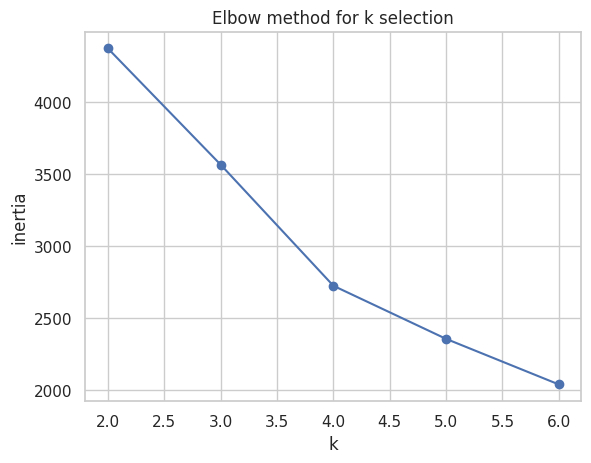

,total_spent,total_purchases,Recency,Income
cluster,,,,
0,3185.783133,21.309811,72.721170,68801.927711
1,296.863636,8.542727,49.520909,34850.266364
2,2948.851145,21.087786,21.643130,67781.500000


In [ ]:
# Select features for clustering
cluster_features = ['total_spent','total_purchases','Recency','Income']
cluster_features = [c for c in cluster_features if c in df.columns]
X = df[cluster_features].fillna(0)

# scale
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# choose k via elbow (quick)
inertia = []
K = range(2,7)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(Xs)
    inertia.append(kmeans.inertia_)

plt.figure()
plt.plot(K, inertia, 'o-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('Elbow method for k selection')
plt.show()

# pick k=3 (example)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42).fit(Xs)
df['cluster'] = kmeans.labels_

# Describe clusters
df.groupby('cluster')[cluster_features].mean()

/tmp/ipython-input-1317749657.py:6: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  candidate_features = [c for c in df.columns if c not in ignore and (df[c].dtype in [np.number])]


Classification report:
              precision    recall  f1-score   support

           0       0.90      0.81      0.85       469
           1       0.31      0.48      0.38        83

    accuracy                           0.76       552
   macro avg       0.60      0.65      0.61       552
weighted avg       0.81      0.76      0.78       552

ROC AUC: 0.6622652657538468


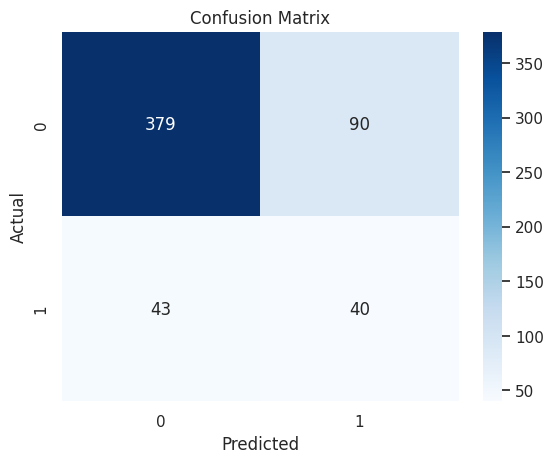

Top negative features:
 Income               -0.480944
avg_purchase_value    1.134117
dtype: float64
Top positive features:
 Income               -0.480944
avg_purchase_value    1.134117
dtype: float64


In [ ]:
# Prepare target and features - exclude identifiers and campaign columns
target = 'Response' if 'Response' in df.columns else None
if target:
    # basic feature list
    ignore = ['DtCustomer','Response'] + cmp_cols if cmp_cols else ['DtCustomer','Response']
    candidate_features = [c for c in df.columns if c not in ignore and (df[c].dtype in [np.number])]

    X = df[candidate_features].fillna(0)
    y = df[target].astype(int)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

    # Handle class imbalance with SMOTE on training set
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    # Pipeline: scaling + logistic regression
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000))
    ])

    pipe.fit(X_train_res, y_train_res)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]

    print("Classification report:")
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
    plt.show()

    # Feature importance (coefficients)
    coefs = pd.Series(pipe.named_steps['clf'].coef_[0], index=X.columns).sort_values()
    print("Top negative features:\n", coefs.head(10))
    print("Top positive features:\n", coefs.tail(10))
else:
    print("No 'Response' column found. Skipping predictive model.")


Percent accepted any campaign: 0.20770975056689342


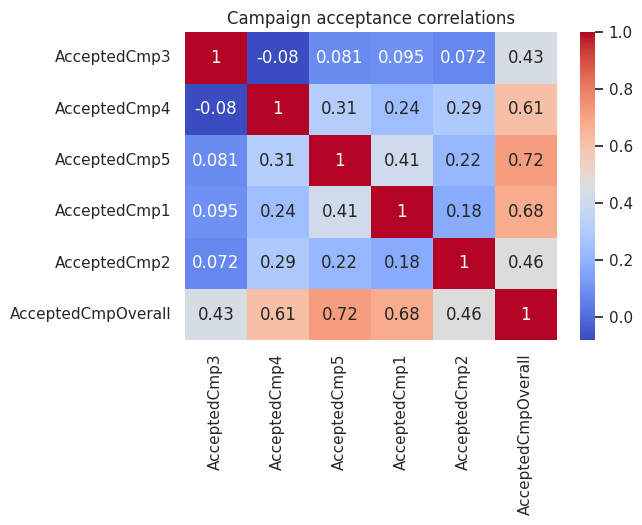

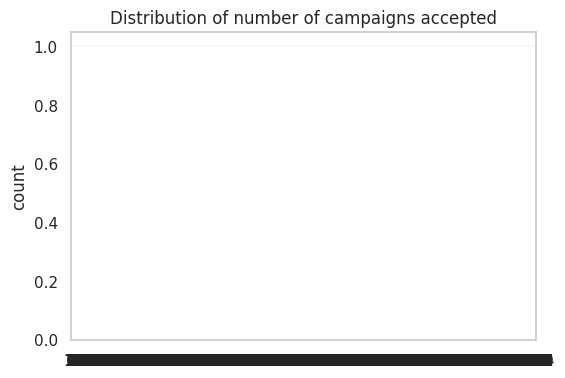

In [ ]:
# Acceptance counts and overlaps
if cmp_cols:
    df['accepted_any'] = df[cmp_cols].sum(axis=1) > 0
    print("Percent accepted any campaign:", df['accepted_any'].mean())

    # Heatmap of campaign co-acceptance correlations
    plt.figure(figsize=(6,4))
    sns.heatmap(df[cmp_cols].corr(), annot=True, cmap='coolwarm')
    plt.title("Campaign acceptance correlations")
    plt.show()

    # Who accepted many campaigns?
    df['accepted_count'] = df[cmp_cols].sum(axis=1)
    plt.figure(figsize=(6,4))
    sns.countplot(df['accepted_count'])
    plt.title("Distribution of number of campaigns accepted")
    plt.show()

In [ ]:
# Flag high-value customers (example): high RFM or cluster
# top RFM decile
if 'rfm_score' in df.columns:
    top_rfm_cut = df['rfm_score'].quantile(0.9)
    df['top_rfm'] = df['rfm_score'] >= top_rfm_cut
    print("Top RFM customers percent:", df['top_rfm'].mean())

# Programmatic recommendation examples:
recommendations = []
recommendations.append("Focus retention campaigns on customers with low Recency but high total_spent (recent high spenders).")
recommendations.append("Target win-back campaigns to customers with high Recency and prior high total_spent (ex-high-value churn).")
recommendations.append("For acquisition: use lookalike of Top-RFM segments and high-protein-product purchasers (or product-specific).")
recommendations.append("Personalize offers: customers who accepted many past campaigns are more responsive; give them loyalty offers.")
recommendations.append("Reduce frequency for customers who complained recently (Complain==1) and contact with service to resolve issues before marketing.")
for r in recommendations:
    print("- ", r)

# Example: flag risky items/customers to call out
if 'Complain' in df.columns:
    complain_rate = df['Complain'].mean()
    print(f"Complaint rate: {complain_rate:.3f}")

Top RFM customers percent: 0.11564625850340136
-  Focus retention campaigns on customers with low Recency but high total_spent (recent high spenders).
-  Target win-back campaigns to customers with high Recency and prior high total_spent (ex-high-value churn).
-  For acquisition: use lookalike of Top-RFM segments and high-protein-product purchasers (or product-specific).
-  Personalize offers: customers who accepted many past campaigns are more responsive; give them loyalty offers.
-  Reduce frequency for customers who complained recently (Complain==1) and contact with service to resolve issues before marketing.
Complaint rate: 0.009


In [ ]:
# ✅ Save cleaned dataset
df.to_csv("ifood_df_cleaned.csv", index=False)
print("✅ Cleaned dataset saved as: ifood_df_cleaned.csv")

# ✅ Save numeric summary
numeric_summary = df.describe()
numeric_summary.to_csv("numeric_summary.csv")
print("📊 Numeric summary saved as: numeric_summary.csv")

# ✅ Save correlation matrix
corr_matrix = df.corr()
corr_matrix.to_csv("correlation_matrix.csv")
print("📈 Correlation matrix saved as: correlation_matrix.csv")

# ✅ Save category distributions for available categorical columns
cat_cols = ['Education', 'Marital']  # or replace with your actual column names
for col in cat_cols:
    if col in df.columns:
        df[col].value_counts().to_csv(f"{col}_value_counts.csv")
        print(f"📁 Value counts saved for {col} → {col}_value_counts.csv")
    else:
        print(f"⚠ Column '{col}' not found in dataset — skipped.")

✅ Cleaned dataset saved as: ifood_df_cleaned.csv
📊 Numeric summary saved as: numeric_summary.csv
📈 Correlation matrix saved as: correlation_matrix.csv
⚠ Column 'Education' not found in dataset — skipped.
⚠ Column 'Marital' not found in dataset — skipped.
